In [2]:
%pip install networkx

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import random as rd
import math

import matplotlib.pyplot as plt
import networkx as nx
from sklearn.datasets import make_blobs, make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import src.privacy_ml as ml #import split_horizontally, split_into_random_subsets, stepForward, stepForwardMono, stepForward_2
import src.logistic_reg as lr #import cost
import src.util as util

%load_ext autoreload
%autoreload 2

In [17]:
priv_util_trd = {}
#dimensions = [10, 30, 50]
mu = [0.00001, 0.00002, 0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 500, 1000]

Alone: 1e-05
Iter: Agents_Mean       | Total 
  0 : (0.9549 , 1.1081) | (18.0359 , 18.0358)
 25 : (0.3431 , 0.5557) | (15.7335 , 15.7335)
 50 : (0.2656 , 0.5040) | (18.8640 , 18.8639)
 75 : (0.2381 , 0.4999) | (22.9107 , 22.9107)
100 : (0.2236 , 0.5072) | (27.0850 , 27.0849)
125 : (0.2144 , 0.5181) | (31.1824 , 31.1824)
150 : (0.2079 , 0.5302) | (35.1469 , 35.1469)
175 : (0.2031 , 0.5425) | (38.9695 , 38.9695)
200 : (0.1993 , 0.5545) | (42.6561 , 42.6561)
225 : (0.1961 , 0.5662) | (46.2165 , 46.2165)
Non Private: 1e-05
Iter: Agents_Mean       | Total 
  0 : (0.9975 , 1.0491) | (1.4677 , 1.4676)
 25 : (0.9876 , 1.0533) | (0.0001 , 0.0000)
 50 : (0.9798 , 1.0447) | (0.0001 , 0.0000)
 75 : (0.9721 , 1.0361) | (0.0001 , 0.0000)
100 : (0.9645 , 1.0277) | (0.0001 , 0.0000)
125 : (0.9570 , 1.0195) | (0.0001 , 0.0000)
150 : (0.9497 , 1.0113) | (0.0001 , 0.0000)
175 : (0.9424 , 1.0033) | (0.0001 , 0.0000)
200 : (0.9353 , 0.9954) | (0.0001 , 0.0000)
225 : (0.9283 , 0.9877) | (0.0001 , 0.0000)
Pr

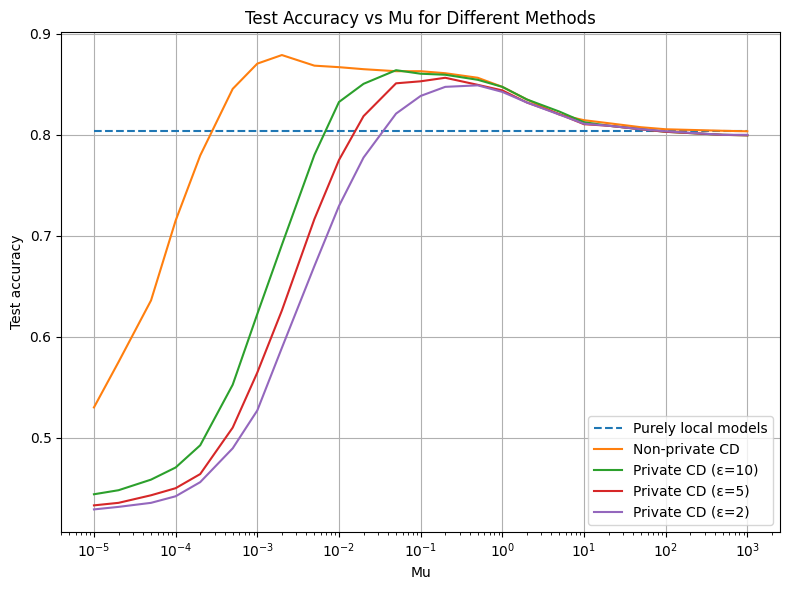

In [18]:
for mu in mu:
    num_agents = 10
    seed = 42
    epsilon_bars = [10, 5, 3]
    T = 250
    #mu = 0.1
    dimensions = 2
    L_0 = 0.25
    lambda_ = 0.1
    sigma = 0.05                                                                                       # randomly chosen at the moment



    data = "classification"

    priv_util_trd[mu] = np.zeros(5)

    if data == "classification":
        X, Y = make_classification(n_samples=1000, n_classes=2, random_state=seed, flip_y=0.05)
    elif data == "moons":
        X, Y = make_moons(n_samples=1000, noise=0.2, random_state=seed)


    Y_formated = OneHotEncoder(categories='auto').fit_transform(Y.reshape(-1,1)).toarray()
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=seed, test_size=0.2)

    X_agent, Y_agent = ml.split_into_random_subsets(X_train, Y_train, random_state=seed)
    #X_agent, Y_agent = ml.split_horizontally(X_train, Y_train)

    if data == "moons":
        X_agent_augmented = []
        for i in range(num_agents):
            X_agent_augmented.append(np.concatenate([X_agent[i], X_agent[i]**2, X_agent[i]**3, X_agent[i]**4, X_agent[i]**5], axis=1))
        X_test_augmented = np.concatenate([X_test, X_test**2, X_test**3, X_test**4, X_test**5], axis=1)
        X_train_augmented = np.concatenate([X_train, X_train**2, X_train**3, X_train**4, X_train**5], axis=1)
    elif data == "classification":
        X_agent_augmented = X_agent
        X_test_augmented = X_test
        X_train_augmented = X_train

    np.random.seed(seed)

    maxSize = np.max([x.shape[0] for x in X_agent])
    minSize = np.min([x.shape[0] for x in X_agent])
    meanSize = np.mean([x.shape[0] for x in X_agent])

    G, D = ml.construct_G_D(num_agents)

    c = np.zeros(num_agents)
    for i in range(num_agents):
        c[i] = X_agent[i].shape[0]/maxSize

    ##### Multi Agent Alone
    print(f"Alone: {mu}")

    np.random.seed(seed)
    thetas_agents_alone = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]

    costs_train_agents_alone = np.zeros((T, num_agents))
    costs_test_agents_alone = np.zeros((T, num_agents))
    costs_train_alone = np.zeros(T)
    costs_test_alone = np.zeros(T)
    acc_train_agents_alone = np.zeros((T, num_agents))
    acc_test_agents_alone = np.zeros((T, num_agents))
    acc_test_alone_maj = np.zeros(T)

    print("Iter: Agents_Mean       | Total ")
    for i in range(T):
        thetas_agents_alone = ml.stepForwardAlone(thetas_agents_alone, X_agent_augmented, Y_agent, num_agents)
        for j in range(num_agents):
                costs_train_agents_alone[i,j] = lr.cost(thetas_agents_alone[j], X_agent_augmented[j], Y_agent[j])
                costs_test_agents_alone[i,j] = lr.cost(thetas_agents_alone[j], X_test_augmented, Y_test)

                acc_train_agents_alone[i, j] = lr.accuracy(thetas_agents_alone[j], X_agent_augmented[j], Y_agent[j])
                acc_test_agents_alone[i, j] = lr.accuracy(thetas_agents_alone[j], X_test_augmented, Y_test)

        costs_train_alone[i] = lr.costDecentralized(thetas_agents_alone, X_agent_augmented, Y_agent, num_agents, G, D, c, mu)
        costs_test_alone[i] = lr.costDecentralized(thetas_agents_alone, X_test_augmented, Y_test, num_agents, G, D, c, mu)
        acc_test_alone_maj[i] = lr.accuracyMajorityVote(num_agents, thetas_agents_alone, X_test_augmented, Y_test)

        if i % (T/10) == 0 :
            print(f'{i:3} : ({np.mean(costs_train_agents_alone[i]):.4f} , {np.mean(costs_test_agents_alone[i]):.4f}) | ({costs_train_alone[i]:.4f} , {costs_test_alone[i]:.4f})')

    priv_util_trd[mu][0] = np.mean(acc_test_agents_alone, axis=1)[-1]

    #### Multi Agent non private
    print(f"Non Private: {mu}")

    np.random.seed(seed)
    thetas_agents = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]

    costs_train_agents = np.zeros((T, num_agents))
    costs_test_agents = np.zeros((T, num_agents))
    costs_train = np.zeros(T)
    costs_test = np.zeros(T)
    acc_train_agents = np.zeros((T, num_agents))
    acc_test_agents = np.zeros((T, num_agents))
    acc_test_maj = np.zeros(T)

    print("Iter: Agents_Mean       | Total ")
    for i in range(T):
        thetas_agents = ml.stepForward(thetas_agents, X_agent_augmented, Y_agent, num_agents, mu, c, G, D)
        for j in range(num_agents):
                costs_train_agents[i,j] = lr.cost(thetas_agents[j], X_agent_augmented[j], Y_agent[j])
                costs_test_agents[i,j] = lr.cost(thetas_agents[j], X_test_augmented, Y_test)

                acc_train_agents[i,j] = lr.accuracy(thetas_agents[j], X_agent_augmented[j], Y_agent[j])
                acc_test_agents[i,j] = lr.accuracy(thetas_agents[j], X_test_augmented, Y_test)
        costs_train[i] = lr.costDecentralized(thetas_agents, X_agent_augmented, Y_agent, num_agents, G, D, c, mu)
        costs_test[i] = lr.costDecentralized(thetas_agents, X_test_augmented, Y_test, num_agents, G, D, c, mu)
        acc_test_maj[i] = lr.accuracyMajorityVote(num_agents, thetas_agents, X_test_augmented, Y_test)
        if i % (T/10) == 0 :
            print(f'{i:3} : ({np.mean(costs_train_agents[i]):.4f} , {np.mean(costs_test_agents[i]):.4f}) | ({costs_train[i]:.4f} , {costs_test[i]:.4f})')

    priv_util_trd[mu][1] = np.mean(acc_test_agents, axis=1)[-1]

    #### Multiple Agents Private sharing
    for ep in range(len(epsilon_bars)):  
        print(f"Private: {epsilon_bars[ep]} {mu}")
  
        np.random.seed(seed)
        tracking  = np.zeros(num_agents)
        total_T = T*num_agents

        thetas_agents_private_weigh_2 = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]
        costs_test_agents_private_weigh_2 = np.zeros((total_T, num_agents))                 # ici on ne gardera en mémoire que les dernières valeurs
        costs_train_agents_private_weigh_2 = np.zeros((total_T, num_agents))
        costs_test_private_weigh_2 = np.zeros(total_T)
        costs_train_private_weigh_2 = np.zeros(total_T)

        acc_test_agents_private_weigh_2 = np.zeros((total_T, num_agents))                 # ici on ne gardera en mémoire que les dernières valeurs
        acc_train_agents_private_weigh_2 = np.zeros((total_T, num_agents))



        # on obtient les probabilités qu'on veut pour chaque modèle à chaque tirage
        coeffs_pond = np.zeros(num_agents)
        c_tot = 0
        for i in range (len(c)) :
            c_tot += c[i]    
        for i in range (len(c)) :
            coeffs_pond[i] = c[i]/c_tot
            
        # on doit calculer grand C = 1 - sigma /(n*Lmax)
        # sigma - strongly convex  : correspond à Ql
        # Lmax : max Li, les Li sont les constantesblock lipschitz du gradient de Ql
        Lmax = ml.computeLMax(D, c, mu, L_0, X_agent_augmented) #roughly 250 in our case
        epsilon_bar = epsilon_bars[ep]

        big_c = 1 - sigma/(num_agents*Lmax)
        cube = big_c ** (1/3)
        print(cube)
        print()

        lambdas = np.zeros(num_agents)
        agent_choice = np.zeros(total_T)
        agent_pre = np.zeros(total_T)
        epsilons = np.zeros(total_T)

        # we have to know in advance at which iterations each machine wakes up, and we compute our lambdas


        for i in range(total_T) :
            j = np.random.choice(10, 1, p=coeffs_pond)[0]
            agent_choice[i] = j
            res = (cube-1) / ((cube ** total_T)-1) * (cube ** (i+1))
            agent_pre[i] = res
            lambdas[j] += res
            
        for i in range(total_T) :
            epsilons[i] = agent_pre[i] * epsilon_bar / lambdas[int(agent_choice[i])]
            

        count = 0
        sum = 0
        epsi_by_agent  = np.zeros(num_agents)
        count_by_agent = np.zeros(num_agents)
        first = np.zeros(num_agents)
        last = np.zeros(num_agents)

        for i in range(total_T):    
            if epsi_by_agent[int(agent_choice[i])] == 0:
                first[int(agent_choice[i])] = epsilons[i]
            last[int(agent_choice[i])] = epsilons[i]
            epsi_by_agent[int(agent_choice[i])] +=epsilons[i]
            count_by_agent[int(agent_choice[i])] += 1
            
        for i in range(num_agents):
            epsi_by_agent[i] = epsi_by_agent[i] / count_by_agent[i]

        rate_epsi = first - last


        print(coeffs_pond)
        print("Iter: Agents_Mean       | Total ")

        for i in range(total_T) :
            j = int(agent_choice[i])
            epsi = epsilons[i]
            thetas_agents_private_weigh_2 = ml.stepForwardPrivate_2(thetas_agents_private_weigh_2, X_agent_augmented, Y_agent, j, num_agents, mu, c, G, D, L_0, epsi)

            costs_train_agents_private_weigh_2[i, j] = (lr.cost(thetas_agents_private_weigh_2[j], X_agent_augmented[j], Y_agent[j]))
            costs_test_agents_private_weigh_2[i, j] = (lr.cost(thetas_agents_private_weigh_2[j], X_test_augmented, Y_test))

            acc_train_agents_private_weigh_2[i, j] = lr.accuracy(thetas_agents_private_weigh_2[j], X_agent_augmented[j], Y_agent[j])
            acc_test_agents_private_weigh_2[i, j] = lr.accuracy(thetas_agents_private_weigh_2[j], X_test_augmented, Y_test)

            if i % 10 == 0:
                costs_train_private_weigh_2[int(i/10)] = lr.costDecentralized(thetas_agents_private_weigh_2, X_agent_augmented, Y_agent, num_agents, G, D, c, mu)
                costs_test_private_weigh_2[int(i/10)] = lr.costDecentralized(thetas_agents_private_weigh_2, X_test_augmented, Y_test, num_agents, G, D, c, mu)
                
                
            if i % ((T/10)*num_agents) == 0 :
                print(f'{int(i/num_agents):3} : ({np.mean(costs_train_agents_private_weigh_2[i]):.4f} , {np.mean(costs_test_agents_private_weigh_2[i]):.4f}) | ({costs_train_private_weigh_2[int(i/10)]:.4f} , {costs_test_private_weigh_2[int(i/10)]:.4f})')

        # costs_train_agents_weigh_2 = util.reduce_cost_matrix(costs_train_agents_weigh_2)
        # costs_test_agents_weigh_2 = util.reduce_cost_matrix(costs_test_agents_weigh_2)

        costs_train_agents_private_weigh_shifted_2 = util.shift_non_zero_costs_to_front(costs_train_agents_private_weigh_2)
        costs_test_agents_private_weigh_shifted_2 = util.shift_non_zero_costs_to_front(costs_test_agents_private_weigh_2)

        non_zero_counts = np.count_nonzero(costs_train_agents_private_weigh_shifted_2, axis=0)    
        max_non_zero = np.max(non_zero_counts)
        costs_train_private_weigh_2 = costs_train_private_weigh_2[:T]
        costs_test_private_weigh_2 = costs_test_private_weigh_2[:T]

        acc_train_agents_private_weigh_2 = util.reduce_cost_matrix(acc_train_agents_private_weigh_2)
        acc_test_agents_private_weigh_2 = util.shift_non_zero_costs_to_front(acc_test_agents_private_weigh_2)[:T]

        priv_util_trd[mu][ep+2] = np.mean(util.propagate_last_value(acc_test_agents_private_weigh_2), axis=1)[-1]

print(priv_util_trd)

# Sort the keys to ensure the dimension axis is in ascending order
dims = sorted(priv_util_trd.keys())

# Extract each series of values
pure_local     = [priv_util_trd[d][0] for d in dims]
non_private    = [priv_util_trd[d][1] for d in dims]
private_eps1   = [priv_util_trd[d][2] for d in dims]
private_eps05  = [priv_util_trd[d][3] for d in dims]
private_eps015 = [priv_util_trd[d][4] for d in dims]

# Plot each line
plt.figure(figsize=(8,6))
plt.xscale("log")
plt.plot(dims, pure_local,     linestyle='--', label='Purely local models')
plt.plot(dims, non_private,    linestyle='-',  label='Non-private CD')
plt.plot(dims, private_eps1,   linestyle='-',  label='Private CD (ε=10)')
plt.plot(dims, private_eps05,  linestyle='-',  label='Private CD (ε=5)')
plt.plot(dims, private_eps015, linestyle='-',  label='Private CD (ε=2)')

# Add labels, legend, and grid
plt.xlabel('Mu')
plt.ylabel('Test accuracy')
plt.title('Test Accuracy vs Mu for Different Methods')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()